# PSFs vary as a function of position-in-slit and wavelength
This notebook explores that variation (particularly which of these is more important)

In [4]:
import os
from pathlib import Path

import numpy as np
import cupy as cp
import math


from tqdm.notebook import tqdm

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import table
from astropy import convolution
from astropy import visualization
from astropy import constants
from astropy.stats import sigma_clip
from astropy.io import fits

import specutils
from specutils import manipulation as specman
from specutils import analysis as specan

from jwst import datamodels

import webbpsf

from IPython import display

def play_text_sound(txt):
    os.system(f'espeak -w /tmp/temp.wav "{txt}"')
    return display.Audio(filename='/tmp/temp.wav', autoplay=True)

In [2]:
%matplotlib inline

visualization.quantity_support()
from matplotlib import pyplot as plt

In [3]:
def psf_pix_grid(hdu, scale='arcsec'):
    im = hdu.data
    x = np.arange(im.shape[0])-(psf['OVERDIST'].data.shape[0]-1)/2
    y = np.arange(im.shape[1])-(psf['OVERDIST'].data.shape[1]-1)/2
    if scale == 'arcsec':
        scale = hdu.header['PIXELSCL']*u.arcsec
    elif scale == 'pixel':
        scale = 1
    return np.meshgrid(x*scale, y*scale)

### Display PSFs (varying wavelength and in-slit position)

Position grid at 1 microns


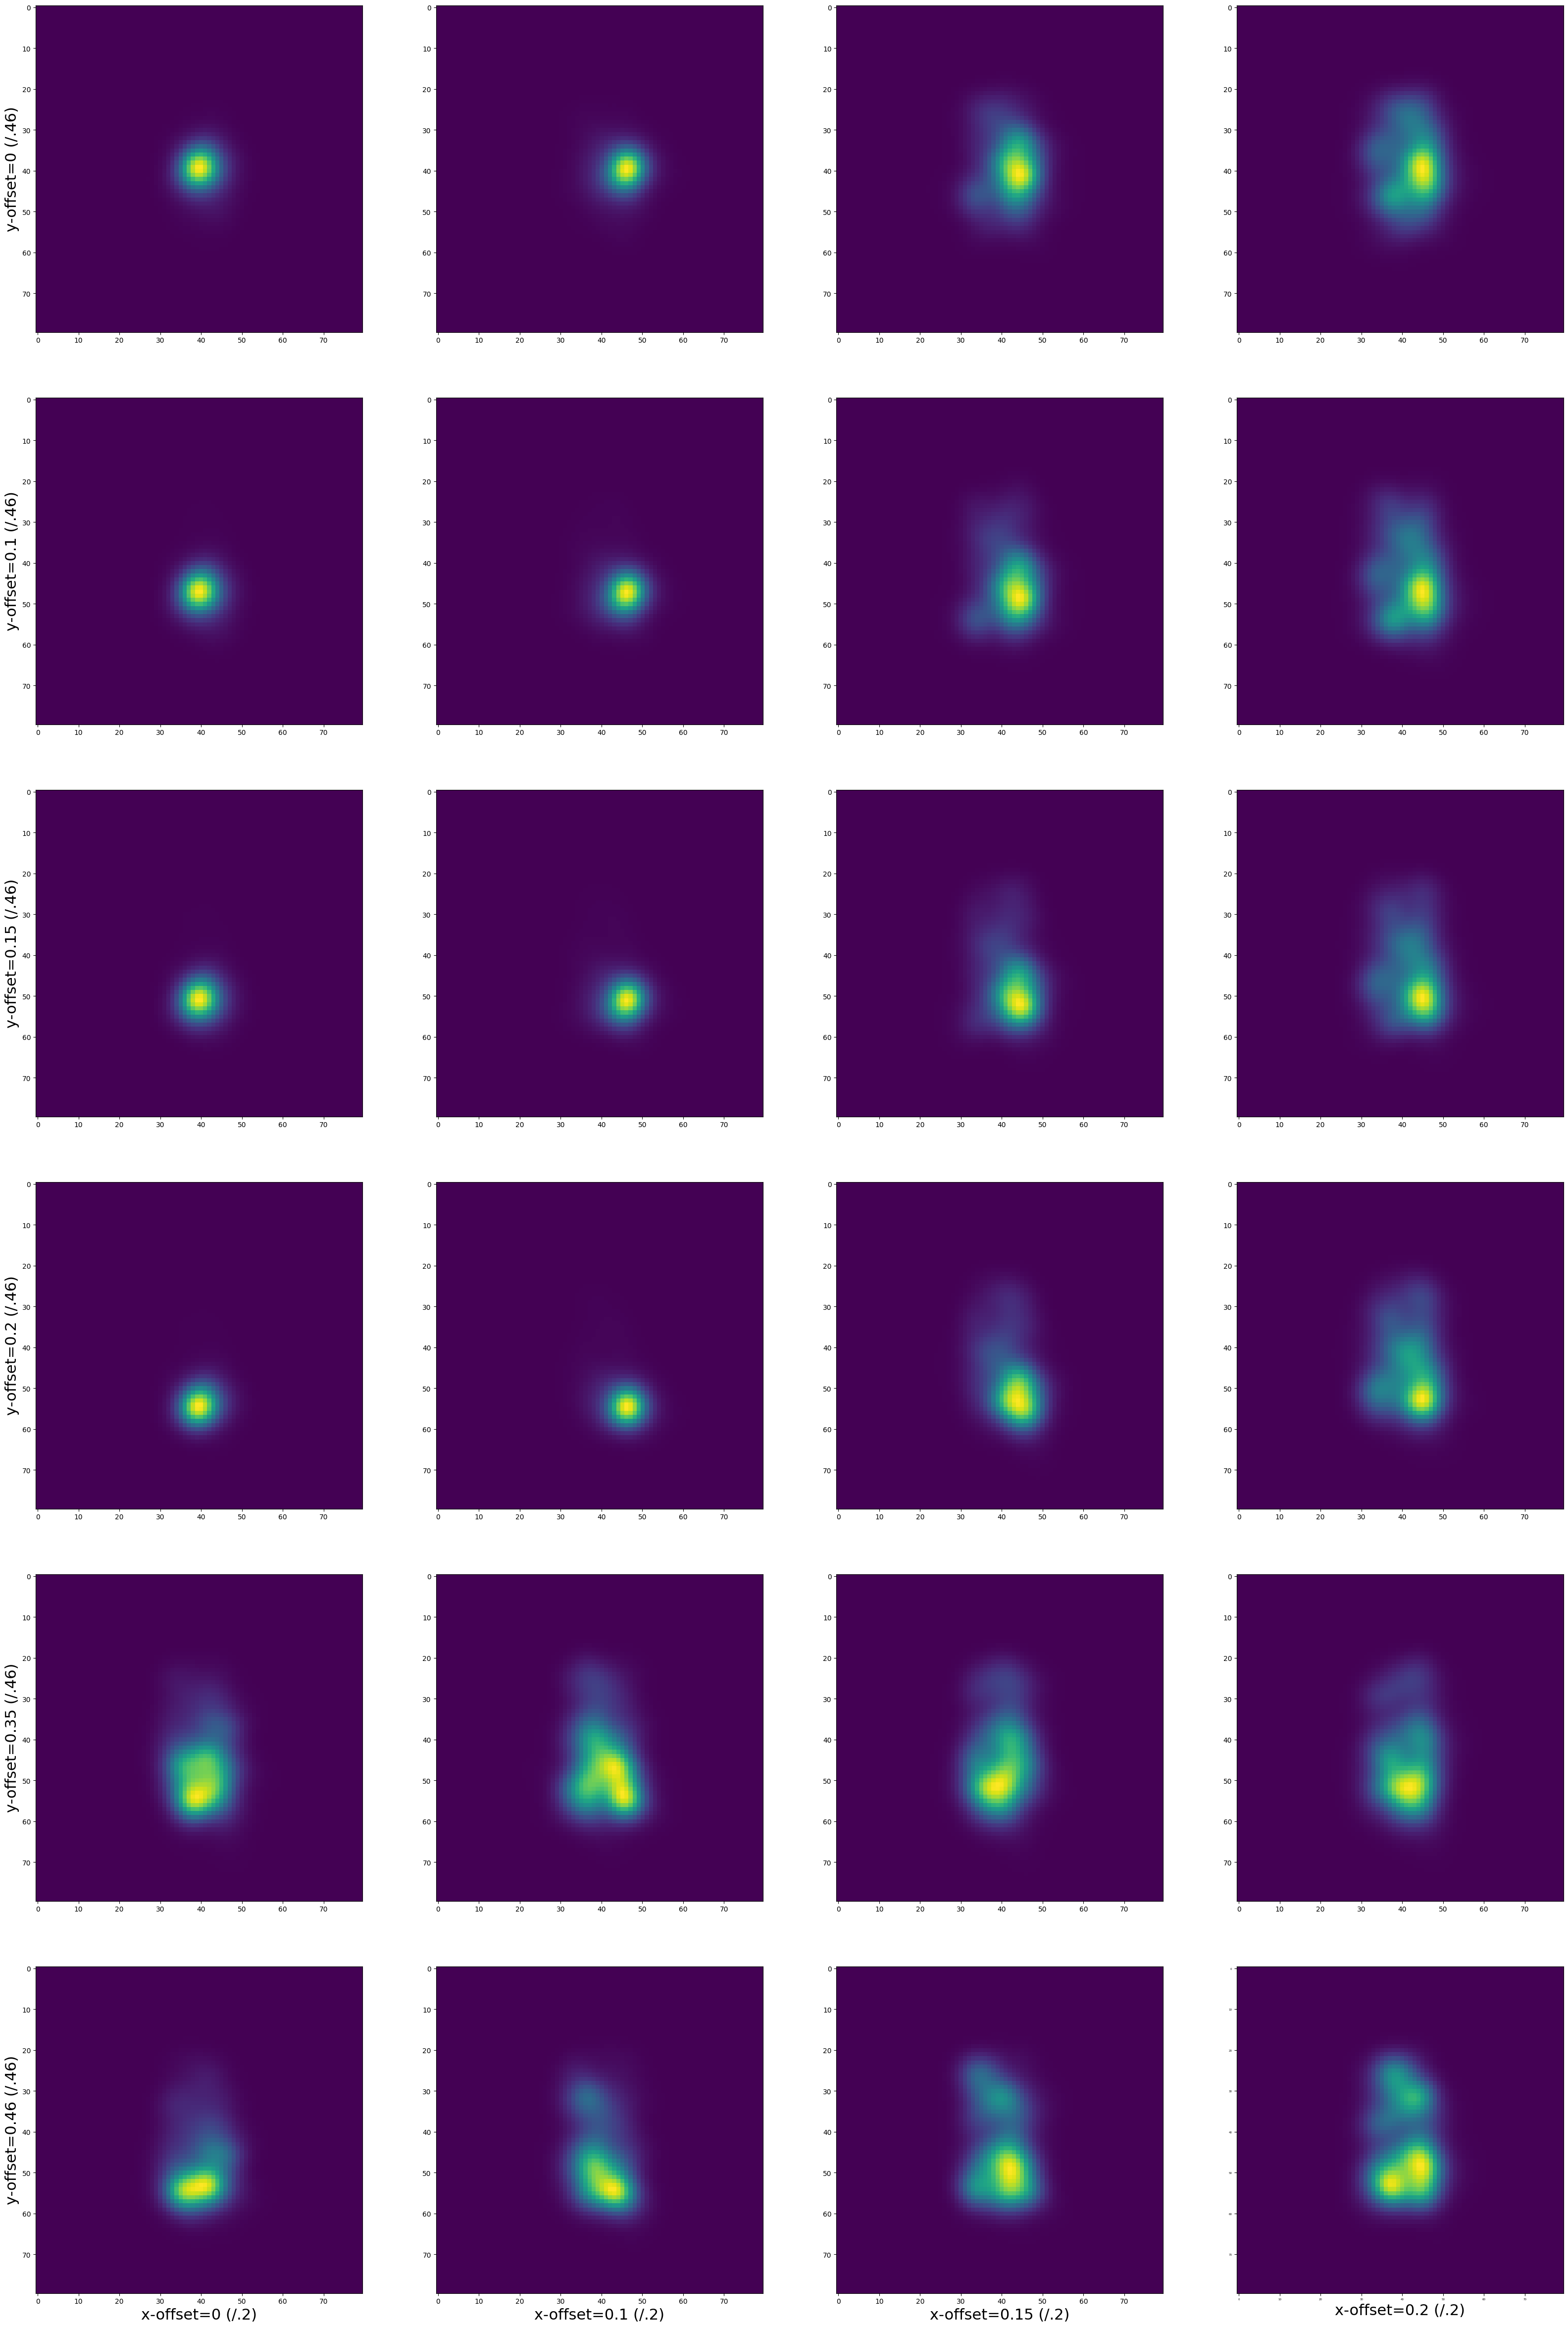


Position grid at 1.2 microns


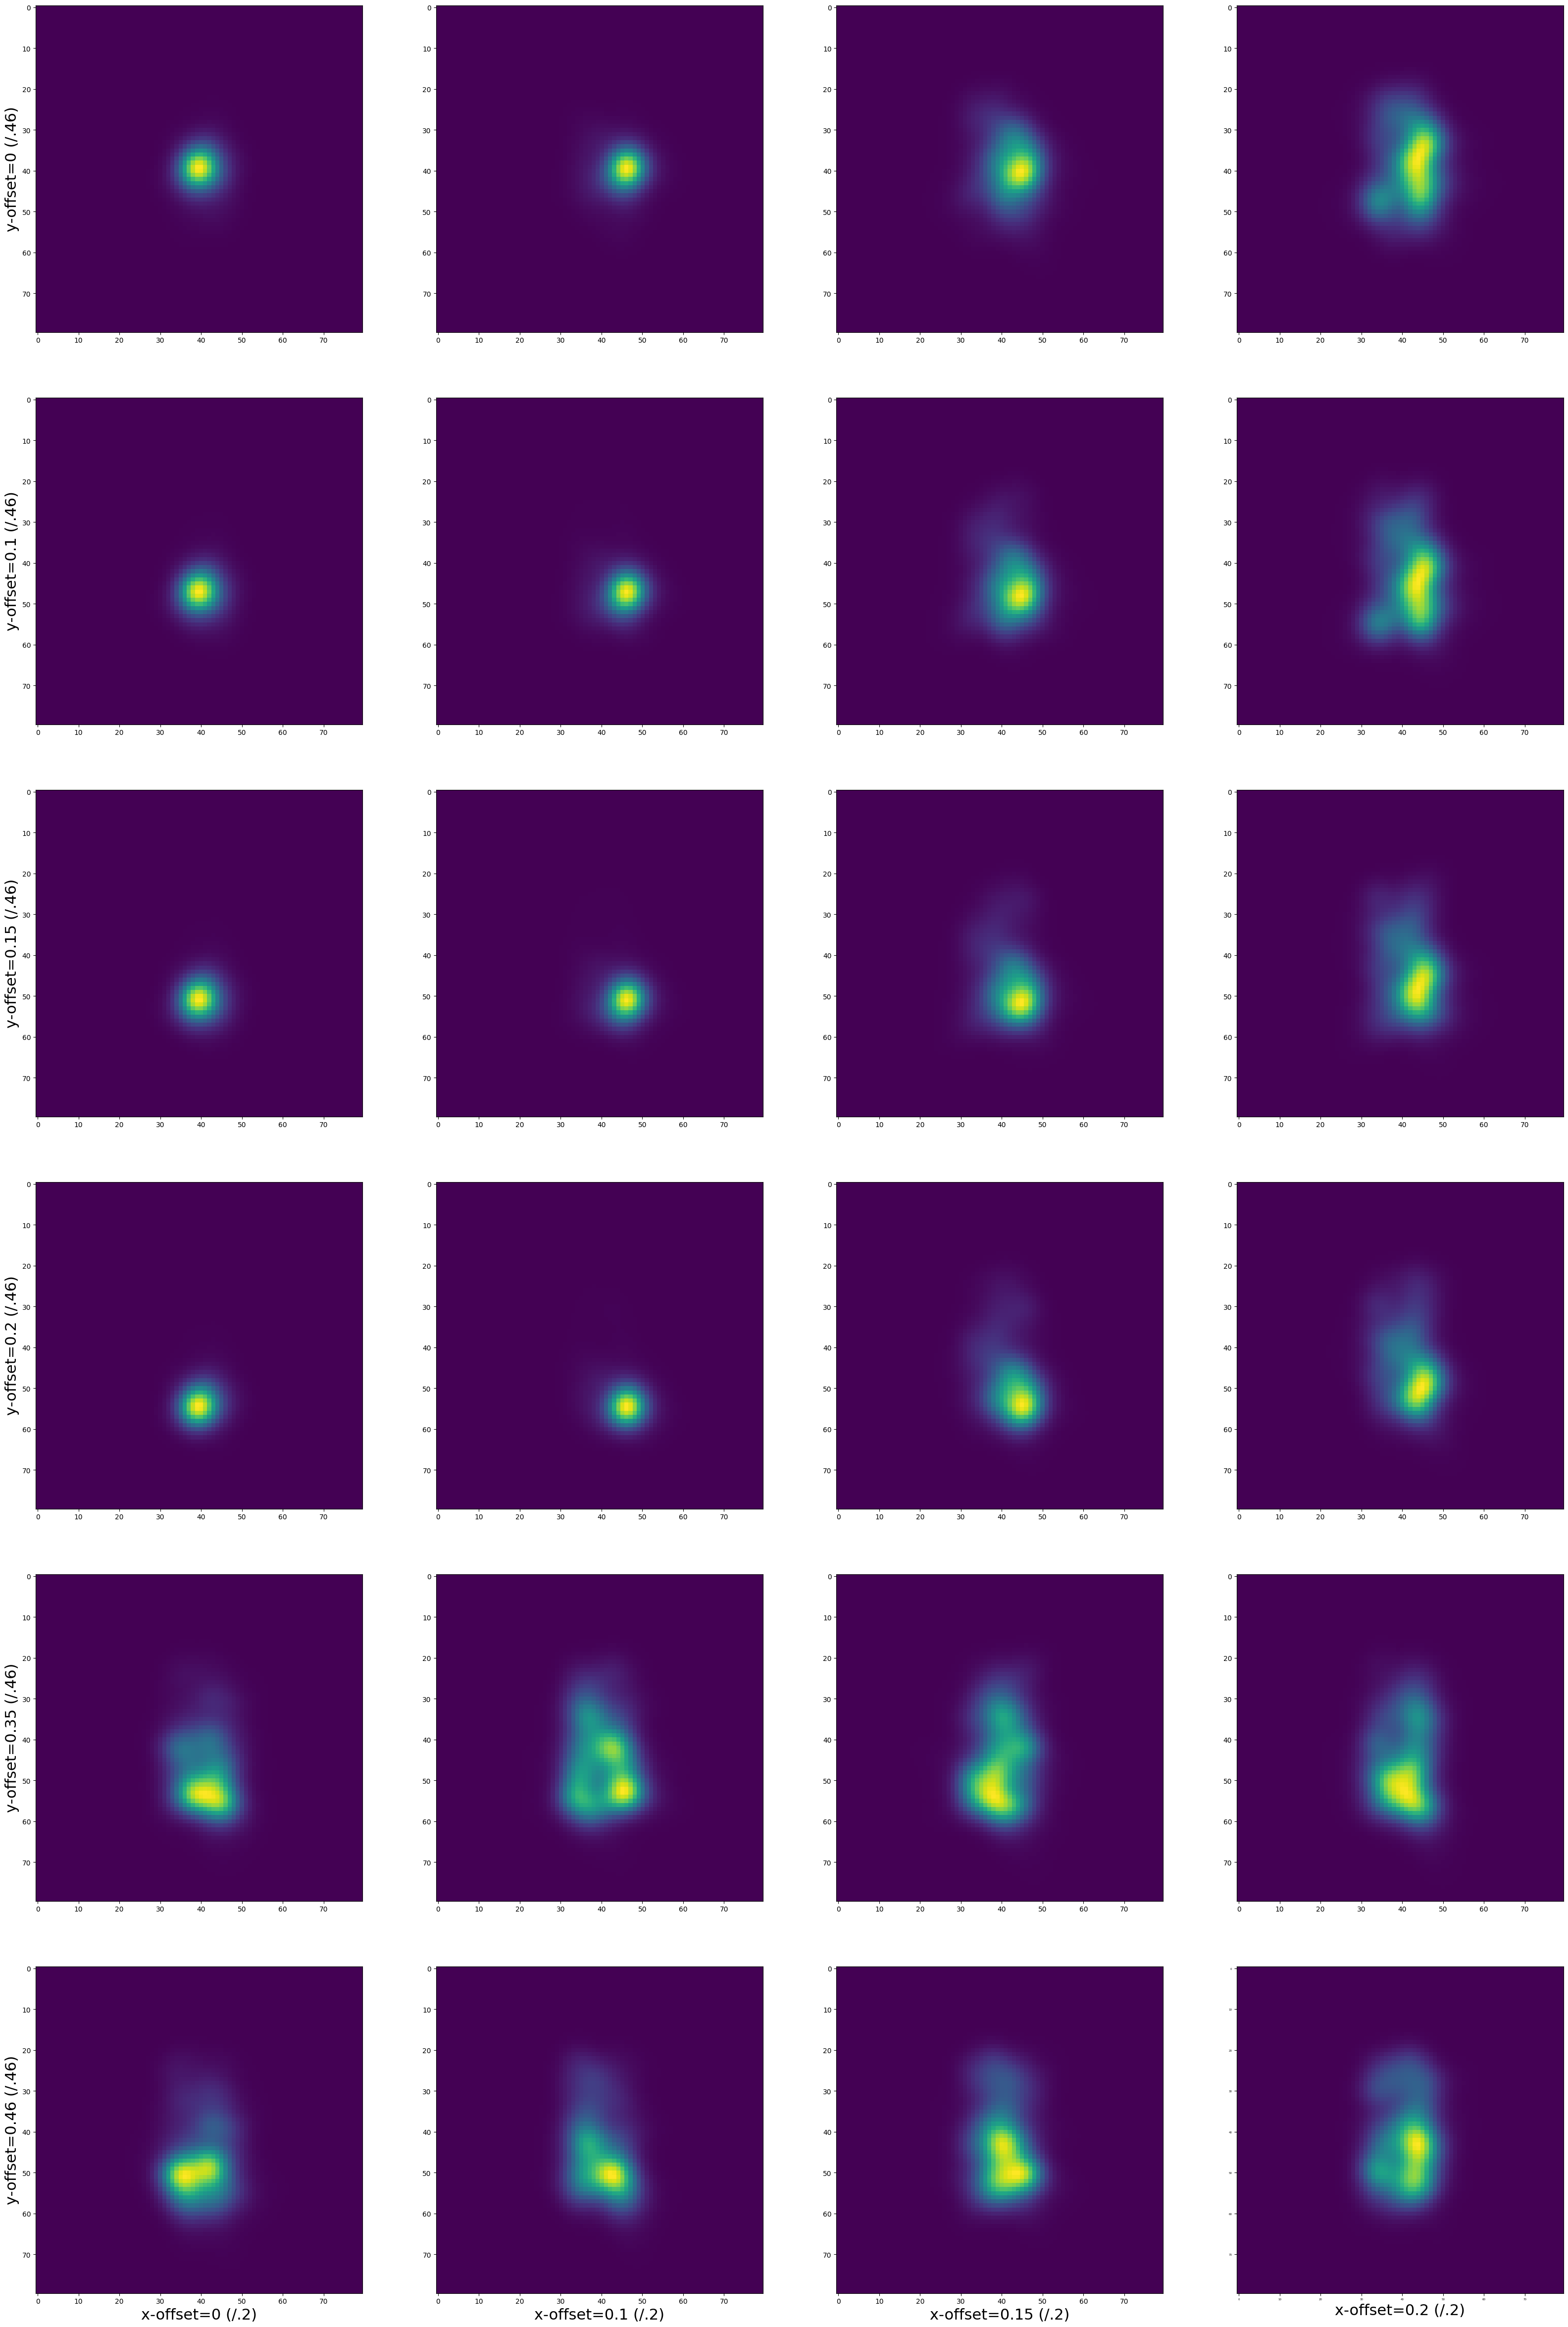


Position grid at 1.4 microns


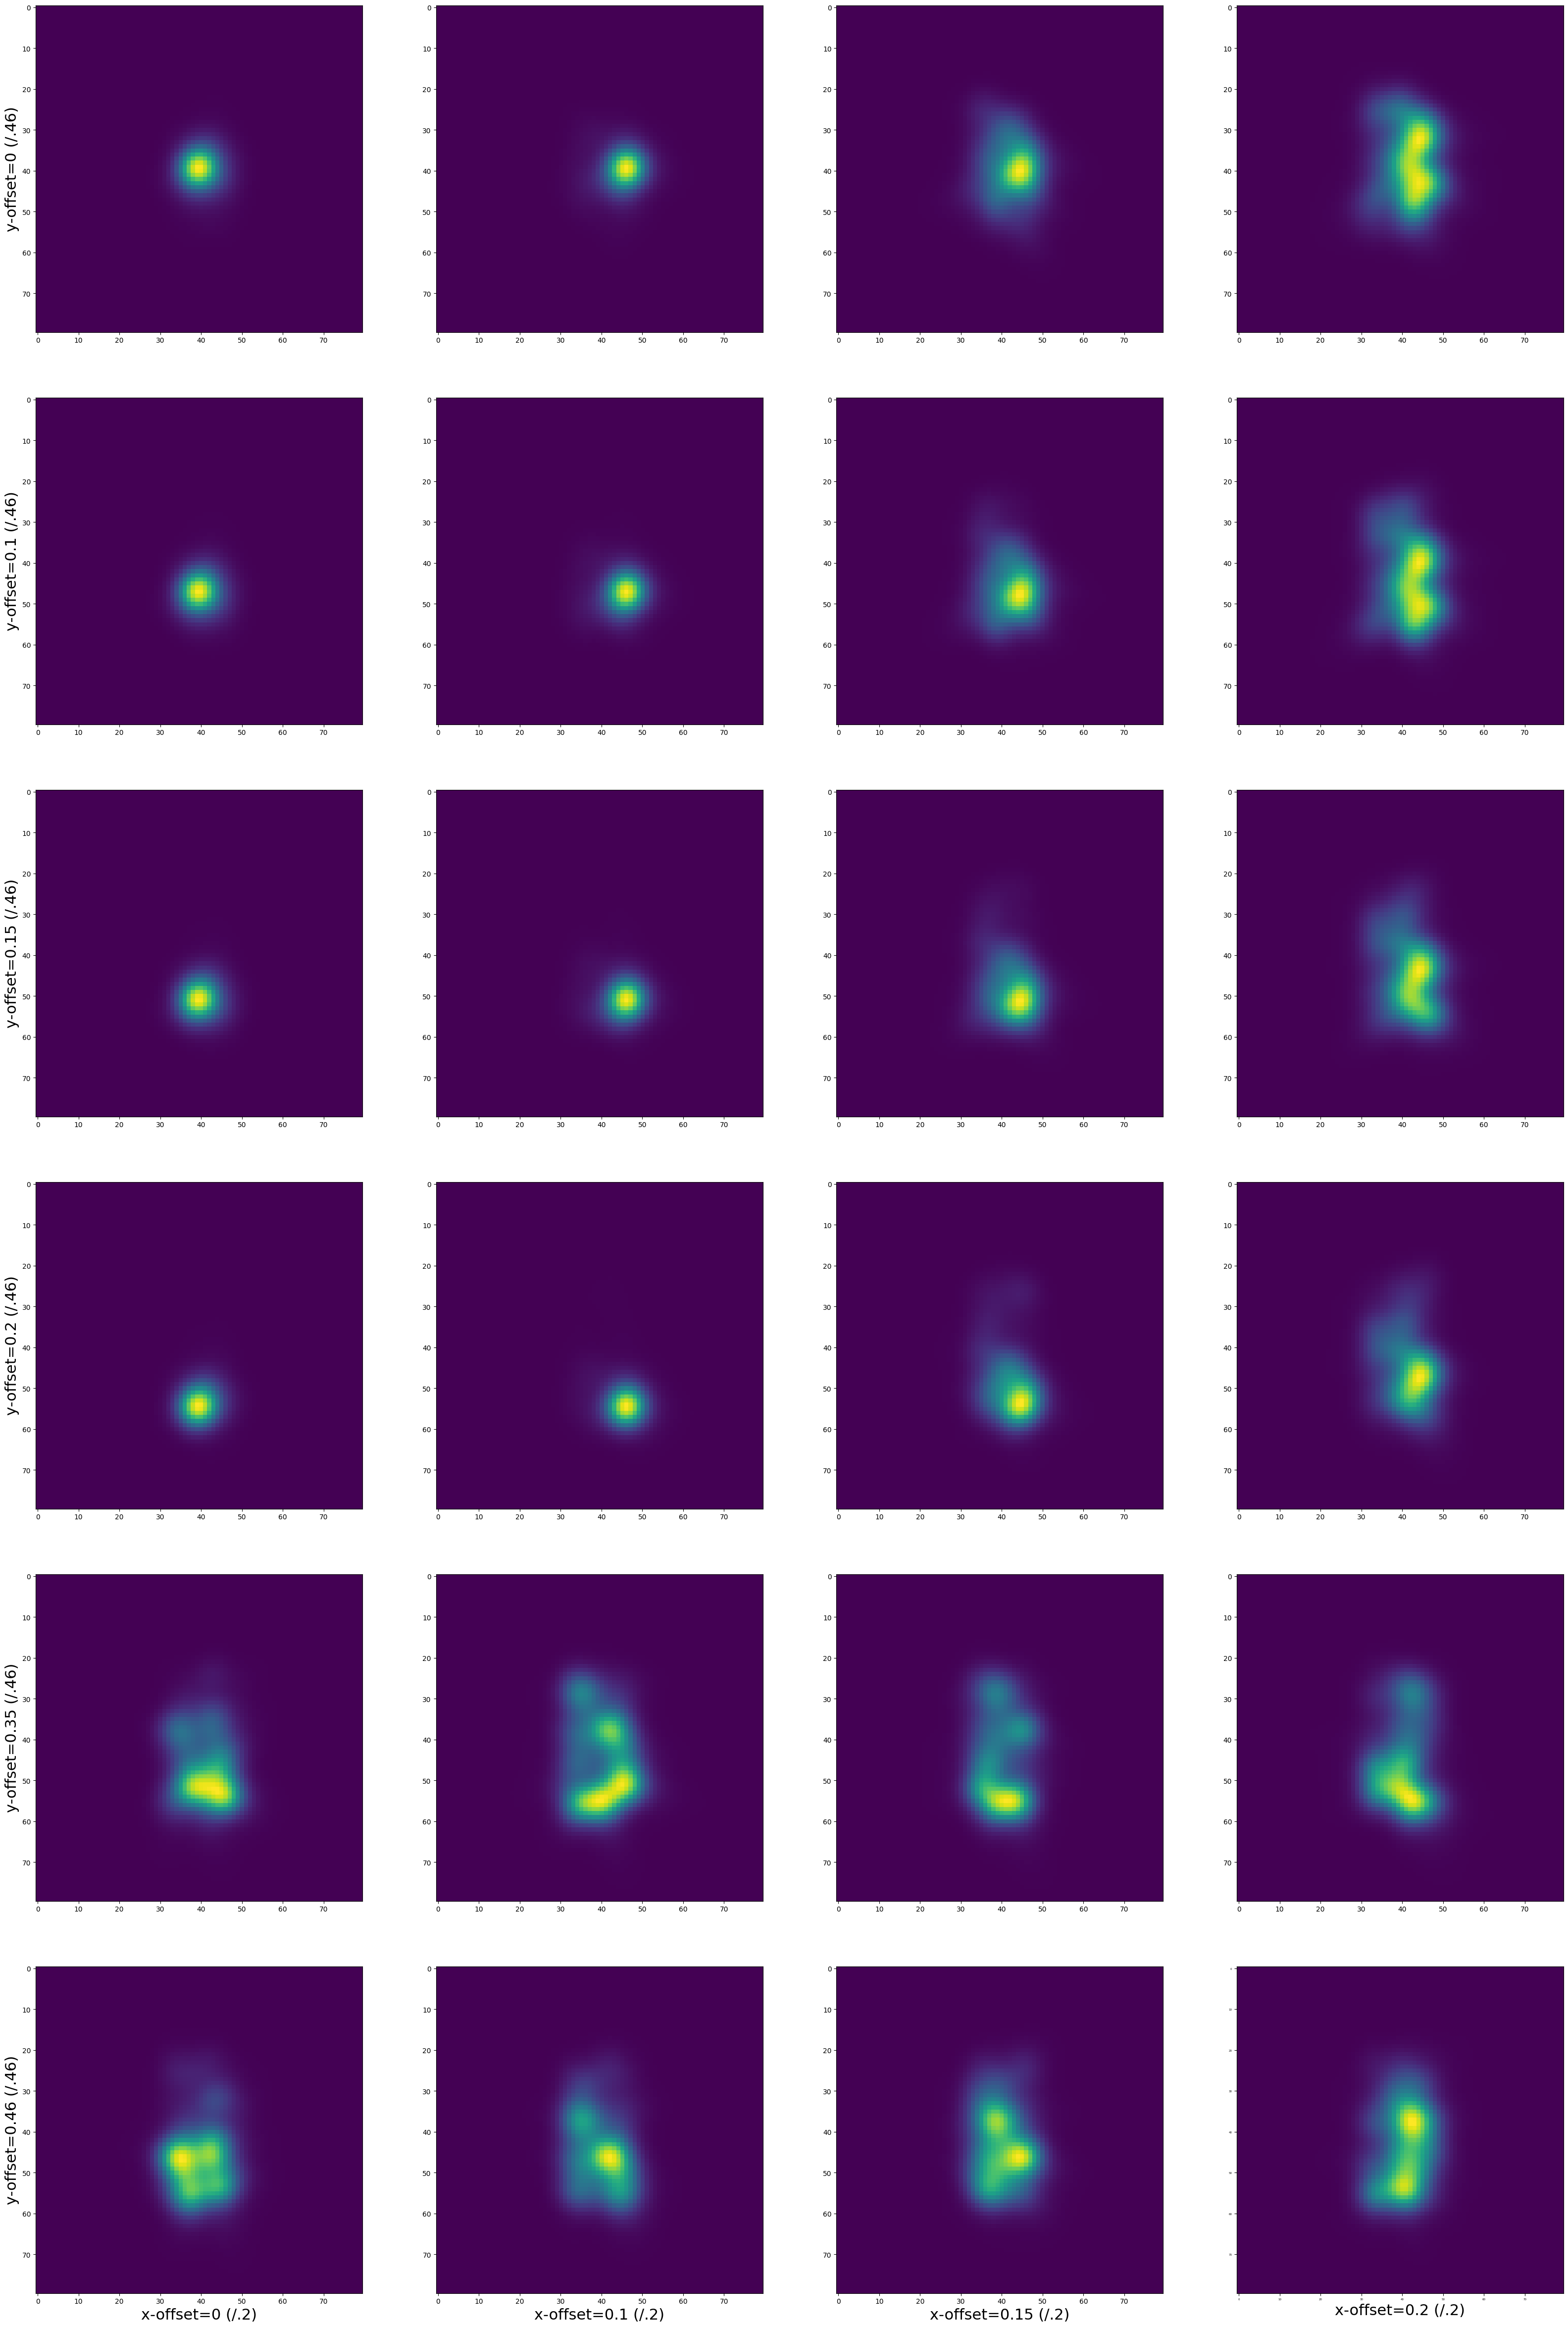


Position grid at 1.6 microns


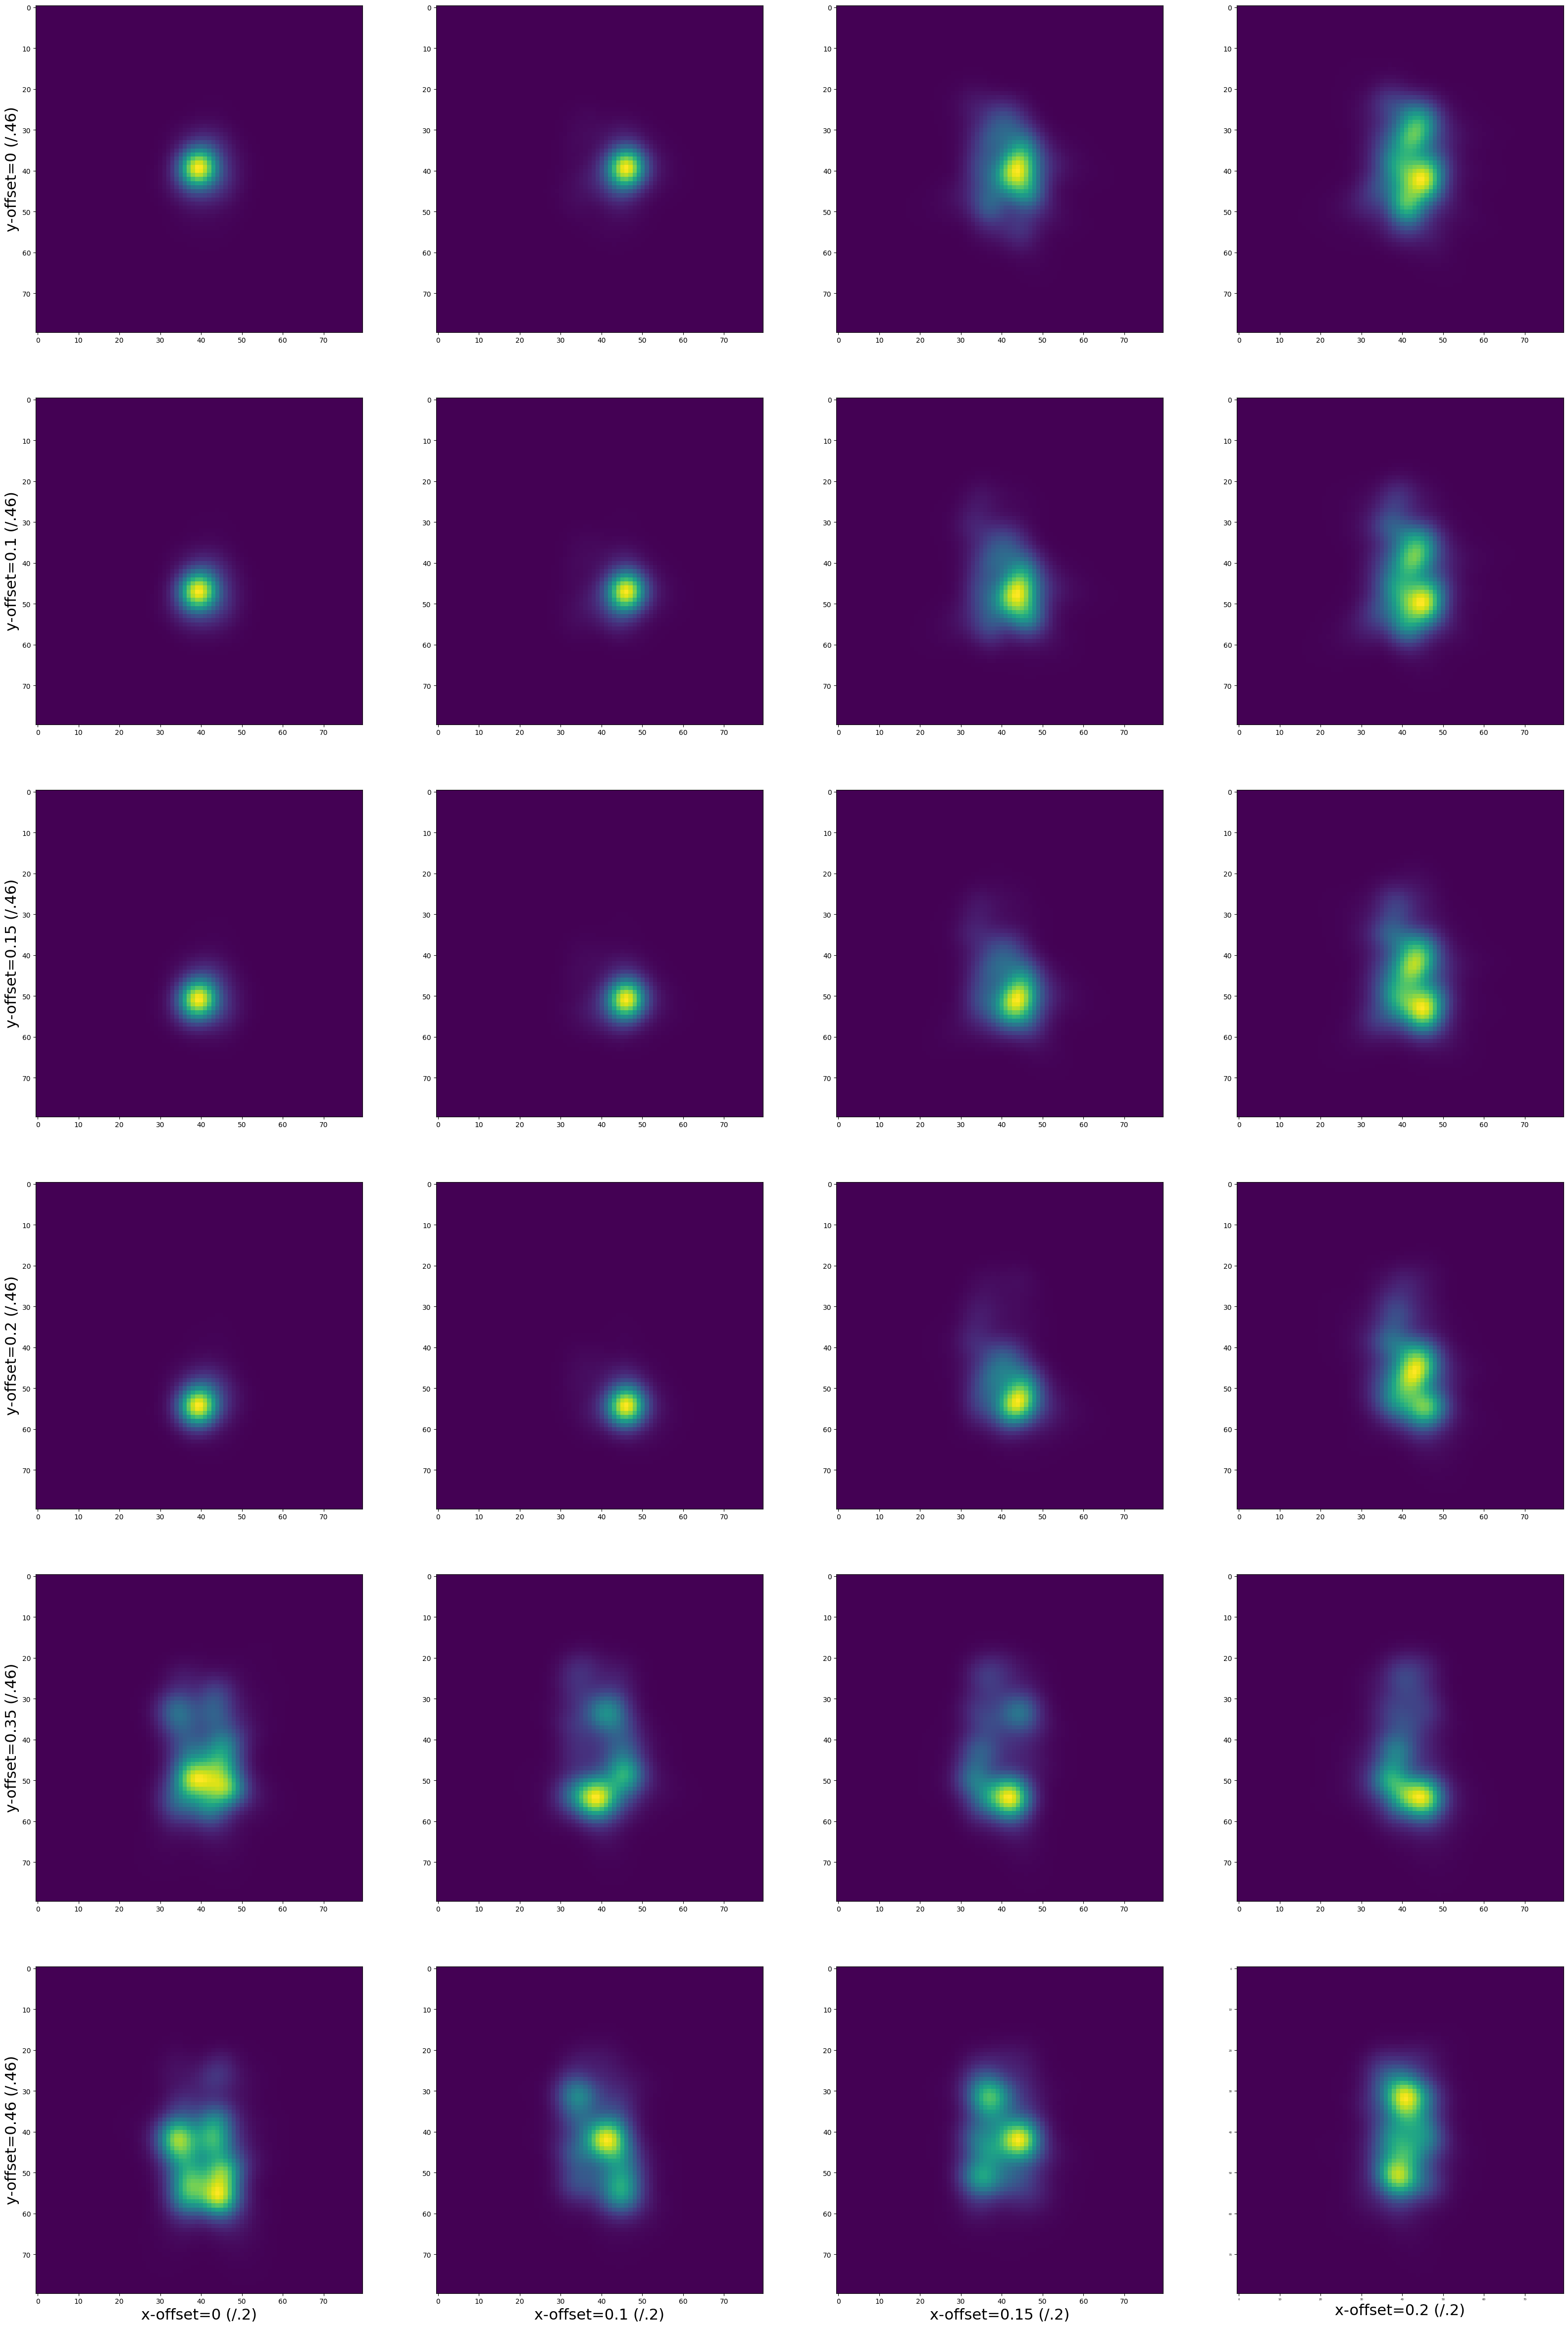


Position grid at 1.8 microns


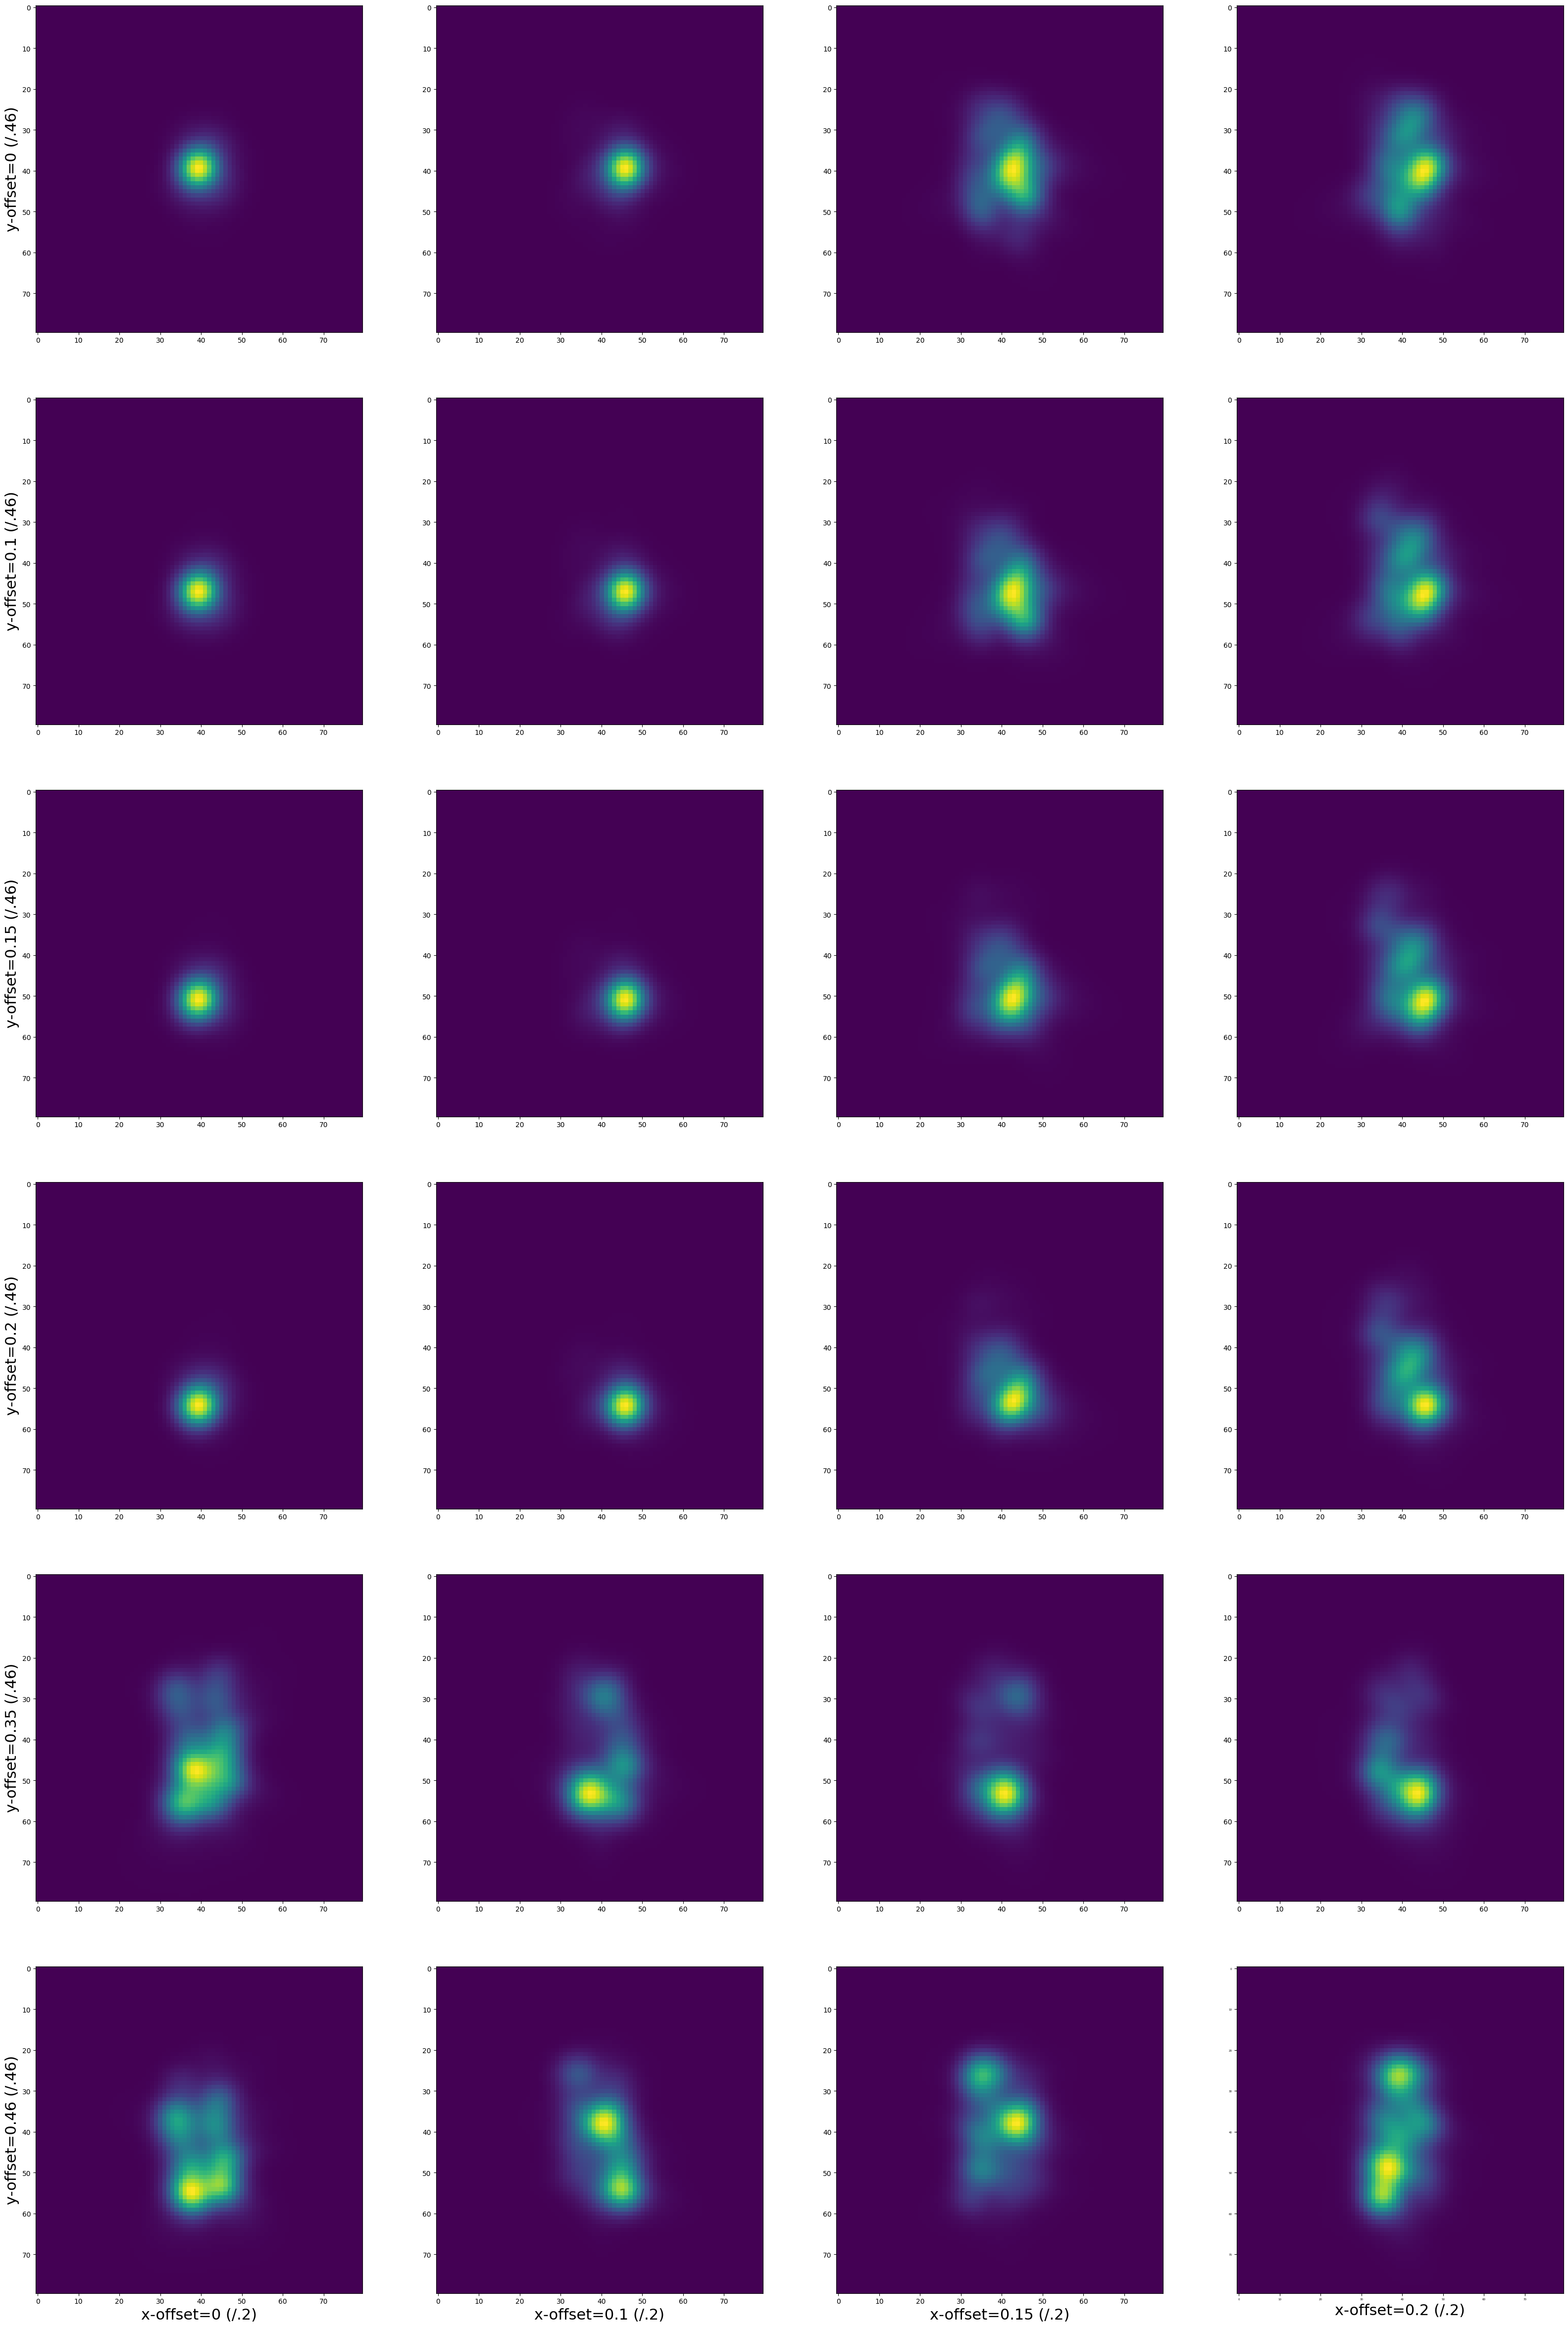

In [24]:
wns = webbpsf.NIRSpec()

wns.detector = 'NRS2'
wns.image_mask = 'Single MSA open shutter'

#I think 0 deg is straight down (negative y direction)



# Set up grid of x and y offsets (in units of arcsecs)
# slit size: 0.20" × 0.46" (x by y, respectively)
xs = [0, 0.1, 0.15, 0.2]
ys = [0, 0.1, 0.15, 0.2, 0.35, 0.46]

for wav in [1, 1.2, 1.4, 1.6, 1.8]:
    print('Position grid at ' + str(wav) + ' microns')
    fig, axs = plt.subplots(6, 4, figsize=(40, 60))
    plt.xticks(fontsize=4)
    plt.yticks(fontsize=4)
    
    for i in range(0, 4):
        for j in range(0, 6):
         # source_offset_r : float
         #        Radial offset of the target from the center, in arcseconds
         #    source_offset_theta : float
         #        Position angle for that offset, in degrees CCW.
            r = np.power(xs[i]**2+ys[j]**2,0.5)
            # avoid annoying divide by 0 issues
            if xs[i] == 0:
                theta = 0
            else:
                theta = math.atan(np.divide(ys[j],xs[i]))*180/math.pi-90
            wns.options['source_offset_r'] = r
            wns.options['source_offset_theta'] = theta
        
            # %time -- add to beginning of next line to print time taken on each grid point
            psf = wns.calc_psf(monochromatic=(wav*u.micron).to(u.meter).value, oversample=8, fov_arcsec=1)
            # print('PSF with r=' + str(r) + ' and theta=' + str(theta) + ' at ' + str(wav) + ' (micron)')
            
            axs[j,i].imshow(psf['OVERDIST'].data)

            if i==3:
                axs[j, 0].set_ylabel('y-offset=' +str(ys[j]) + ' (/.46)', fontsize = 22)
        axs[5,i].set_xlabel('x-offset=' + str(xs[i]) + ' (/.2)', fontsize = 22)
    plt.show()
    print()

NRS1:: Position grid at 1.8 microns


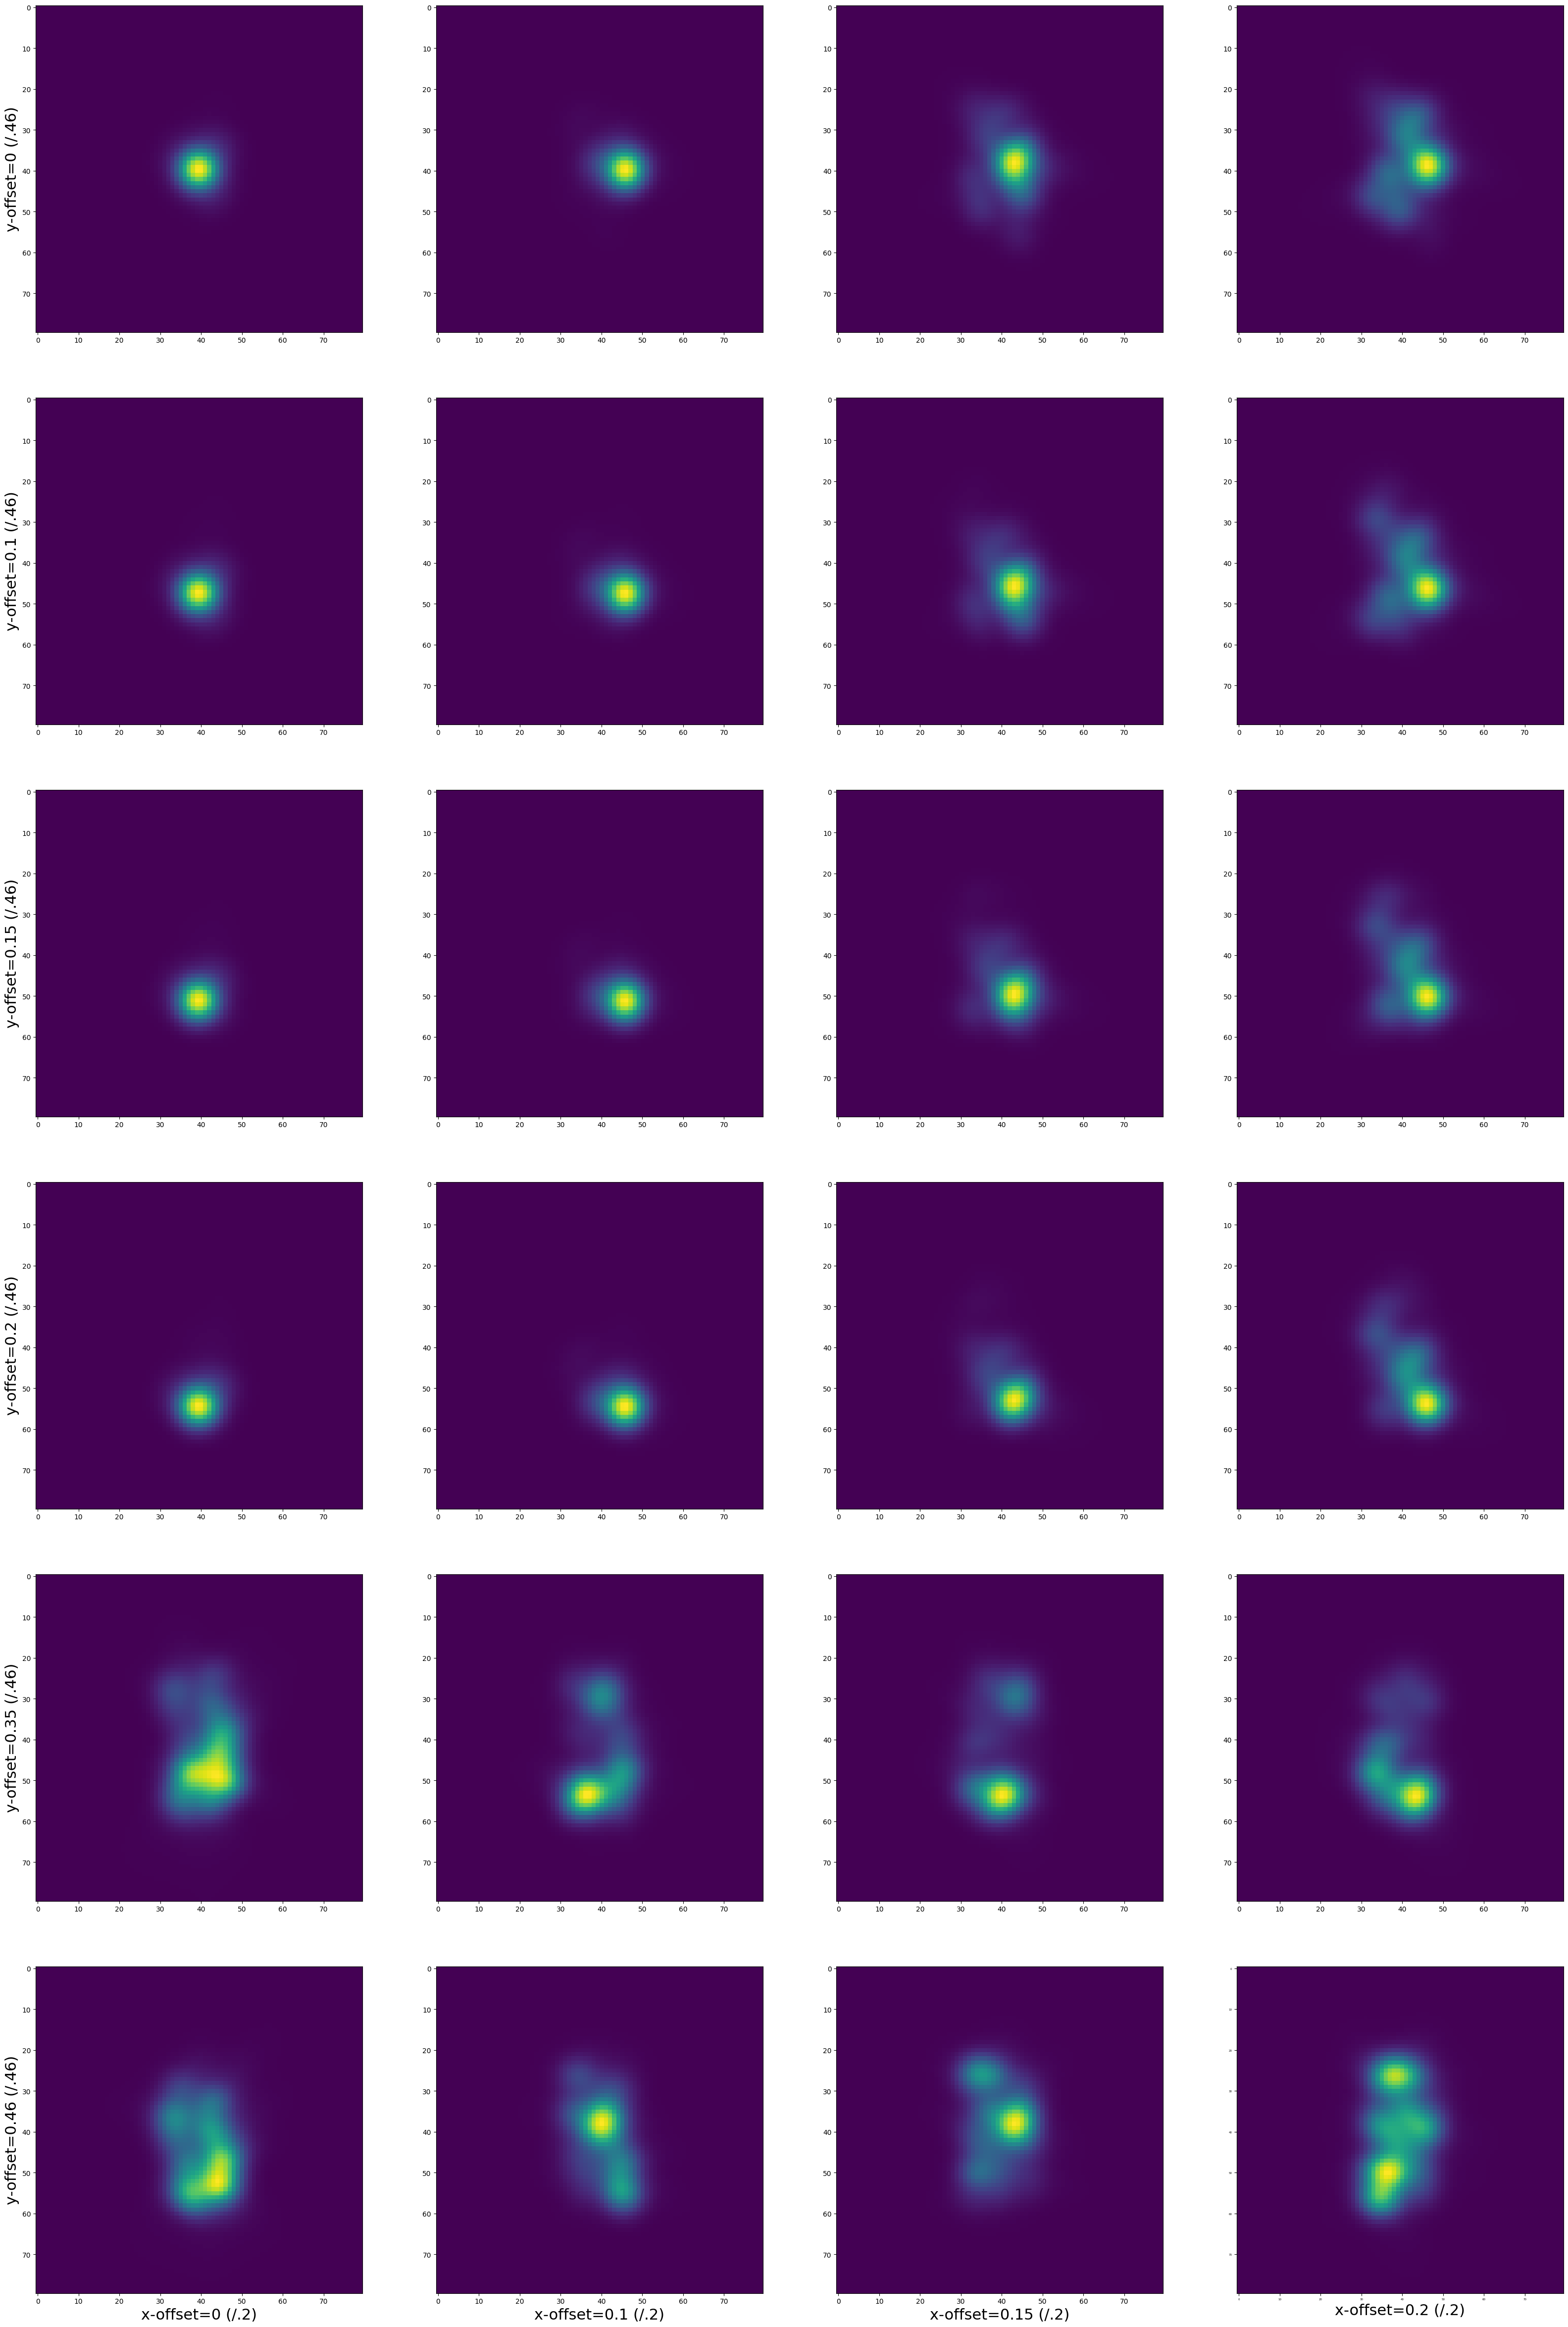

In [27]:
### do we need to calculate a difference in psf between the two detectors?
wns = webbpsf.NIRSpec()

wns.detector = 'NRS1'
wns.image_mask = 'Single MSA open shutter'

#I think 0 deg is straight down (negative y direction)



# Set up grid of x and y offsets
# slit size: 0.20" × 0.46" 
xs = [0, 0.1, 0.15, 0.2]
ys = [0, 0.1, 0.15, 0.2, 0.35, 0.46]

for wav in [1.8]:
    print('NRS1:: Position grid at ' + str(wav) + ' microns')
    fig, axs = plt.subplots(6, 4, figsize=(40, 60))
    plt.xticks(fontsize=4)
    plt.yticks(fontsize=4)
    
    for i in range(0, 4):
        for j in range(0, 6):
         # source_offset_r : float
         #        Radial offset of the target from the center, in arcseconds
         #    source_offset_theta : float
         #        Position angle for that offset, in degrees CCW.
            r = np.power(xs[i]**2+ys[j]**2,0.5)
            # avoid annoying divide by 0 issues
            if xs[i] == 0:
                theta = 0
            else:
                theta = math.atan(np.divide(ys[j],xs[i]))*180/math.pi-90
            wns.options['source_offset_r'] = r
            wns.options['source_offset_theta'] = theta
        
            # %time -- add to beginning of next line to print time taken on each grid point
            psf = wns.calc_psf(monochromatic=(wav*u.micron).to(u.meter).value, oversample=8, fov_arcsec=1)
            # print('PSF with r=' + str(r) + ' and theta=' + str(theta) + ' at ' + str(wav) + ' (micron)')
            
            axs[j,i].imshow(psf['OVERDIST'].data)

            if i==3:
                axs[j, 0].set_ylabel('y-offset=' +str(ys[j]) + ' (/.46)', fontsize = 22)
        axs[5,i].set_xlabel('x-offset=' + str(xs[i]) + ' (/.2)', fontsize = 22)
    plt.show()
    print()

CPU times: user 7.36 s, sys: 19.7 ms, total: 7.38 s
Wall time: 5.56 s
PSF with r=0 and theta=0 at 1 (micron)


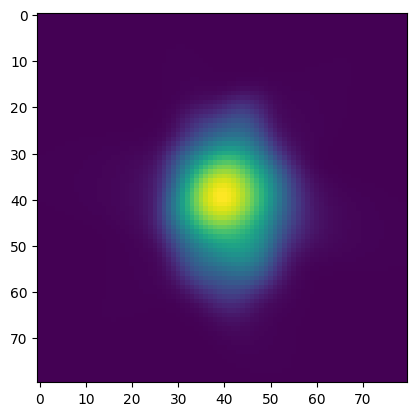

CPU times: user 5.45 s, sys: 50.1 ms, total: 5.5 s
Wall time: 3.77 s
PSF with r=0 and theta=0 at 1.2 (micron)


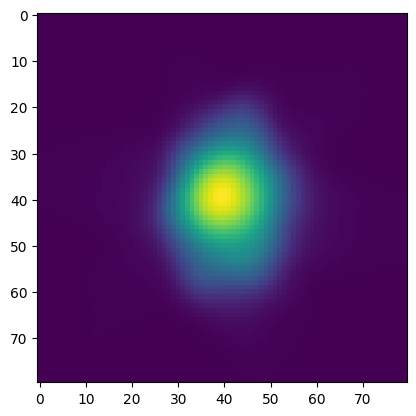

CPU times: user 6.03 s, sys: 60.2 ms, total: 6.09 s
Wall time: 4.38 s
PSF with r=0 and theta=0 at 1.4 (micron)


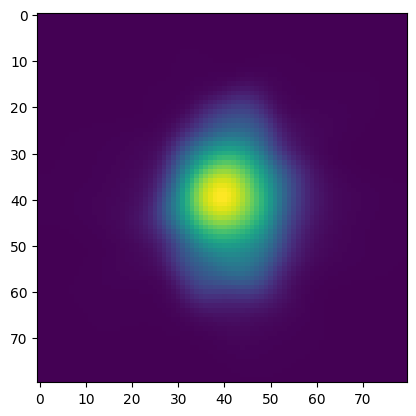

CPU times: user 5.49 s, sys: 20.6 ms, total: 5.51 s
Wall time: 3.78 s
PSF with r=0 and theta=0 at 1.6 (micron)


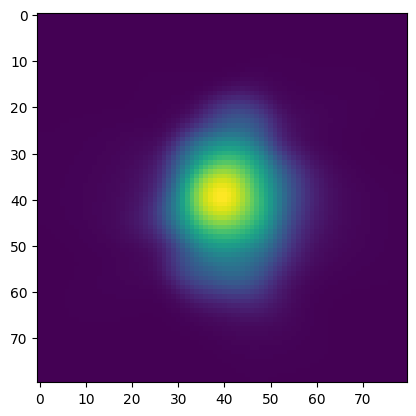

CPU times: user 6.1 s, sys: 88.9 ms, total: 6.19 s
Wall time: 4.56 s
PSF with r=0 and theta=0 at 1.8 (micron)


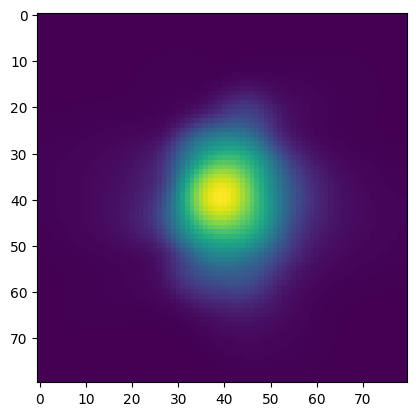

In [12]:
##generate series of plots for different wavelengths and r, theta

wns = webbpsf.NIRSpec()

wns.detector = 'NRS2'
wns.image_mask = 'Single MSA open shutter'

# I think theta = 0 is straight down
for wav in [1, 1.2, 1.4, 1.6, 1.8]:
    for r, theta in [(0,0)]:
                 #     , (0.1, 0), (0.15, 0), (0.2,0), (0.35, 0), (0.46, 0), 
                 # (0,0), (0.1, -90), (0.15, -90), (0.2, -90)]:
        
        wns.options['source_offset_r'] = r
        wns.options['source_offset_theta'] = theta
    
        %time psf = wns.calc_psf(monochromatic=(wav*u.micron).to(u.meter).value, oversample=8, fov_arcsec=1)
        print('PSF with r=' + str(r) + ' and theta=' + str(theta) + ' at ' + str(wav) + ' (micron)')
        visualization.imshow_norm(psf['OVERDIST'].data,
        # visualization.imshow_norm(psf['OVERSAMP'].data, ### this line to swap to psf without pixel-correlation 'smearing' (should be included in real runs)
                              interval=visualization.MinMaxInterval(),
                              stretch=visualization.LogStretch())
        plt.show()

Radius where the flux is within the quantiles [0.5, 0.9, 0.95, 0.99, 0.995, 0.999] :
[0.12411288 0.23356436 0.27132238 0.41142905 0.4765976  0.58145145] arcsec
[ 9.5131488  17.90251379 20.79663434 31.53569406 36.53080892 44.56776923] pix oversampled
[1.1891436  2.23781422 2.59957929 3.94196176 4.56635111 5.57097115] pix detector sampled


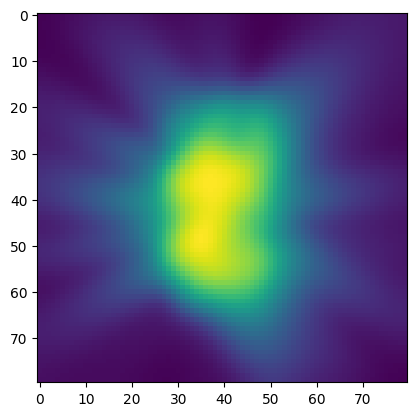

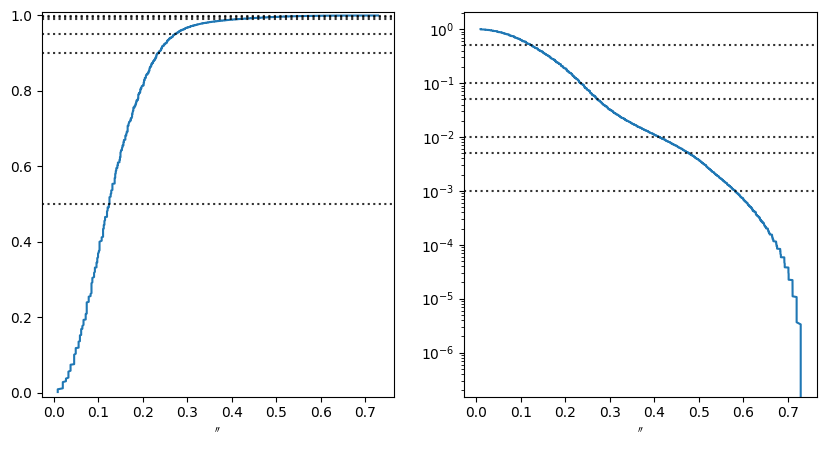

In [30]:
## For generating flux quantiles. Uses whatever psf was generated last in the notebook
hdu = psf['OVERDIST']

visualization.imshow_norm(hdu.data,
                          interval=visualization.MinMaxInterval(),
                          stretch=visualization.LogStretch())


qs = [0.5, 0.9, 0.95, 0.99, 0.995, 0.999]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
pxg, pyg = psf_pix_grid(hdu)
r = np.hypot(pxg, pyg)
sorti = np.argsort(r.ravel())
x = r.ravel()[sorti]
y = np.cumsum(hdu.data.ravel()[sorti])
y = y/y[-1]

ax1.plot(x, y)
ax1.set_ylim(-0.01, 1.01)
for q in qs:
    ax1.axhline(q, c='k', ls=':', alpha=.8)
    
ax2.semilogy(x, 1-y)
for q in qs:
    ax2.axhline(1-q, c='k', ls=':', alpha=.8)

print('Radius where the flux is within the quantiles', qs, ':')
print(np.interp(qs, y, x))
print(np.interp(qs, y, x/(hdu.header['PIXELSCL']*u.arcsec/u.pixel)), 'oversampled')
print(np.interp(qs, y, x/(hdu.header['PIXELSCL']*u.arcsec/u.pixel)/hdu.header['OVERSAMP']), 'detector sampled')

### Determine the pixel-width of the 1-, 2-, and 3-sigma bounds
All numbers of pixels pertaining to width show radius values, so double them to determine the diameter of the spread

CPU times: user 7.35 s, sys: 0 ns, total: 7.35 s
Wall time: 5.8 s
PSF with r=0 and theta=0 at 1 (micron)
[0.75519037 1.4816587  2.65900592] pix detector sampled
CPU times: user 7.28 s, sys: 0 ns, total: 7.28 s
Wall time: 5.75 s
PSF with r=0 and theta=0 at 1.2 (micron)
[0.75519037 1.50260191 2.72860999] pix detector sampled
CPU times: user 7.13 s, sys: 10 μs, total: 7.13 s
Wall time: 5.54 s
PSF with r=0 and theta=0 at 1.4 (micron)
[0.75658579 1.50260191 2.82980786] pix detector sampled
CPU times: user 8.83 s, sys: 0 ns, total: 8.83 s
Wall time: 7.24 s
PSF with r=0 and theta=0 at 1.6 (micron)
[0.79549513 1.54363613 2.93816482] pix detector sampled
CPU times: user 8.37 s, sys: 20 ms, total: 8.39 s
Wall time: 6.82 s
PSF with r=0 and theta=0 at 1.8 (micron)
[0.8149003  1.5637495  3.19300994] pix detector sampled


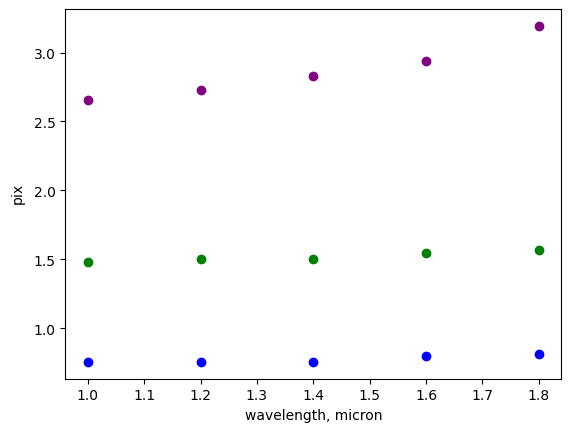

In [29]:
### Varying wavelength, how does the psf pixel-spread change?
wns = webbpsf.NIRSpec()

wns.detector = 'NRS2'
wns.image_mask = 'Single MSA open shutter'

for wav in [1, 1.2, 1.4, 1.6, 1.8]:
    for r, theta in [(0,0)]:
        wns.options['source_offset_r'] = r
        wns.options['source_offset_theta'] = theta
    
        %time psf = wns.calc_psf(monochromatic=(wav*u.micron).to(u.meter).value, oversample=8, fov_arcsec=1)
        print('PSF with r=' + str(r) + ' and theta=' + str(theta) + ' at ' + str(wav) + ' (micron)')
        
        hdu = psf['OVERDIST']

        qs = [0.68, 0.95, 0.997]

        pxg, pyg = psf_pix_grid(hdu)
        r = np.hypot(pxg, pyg)
        sorti = np.argsort(r.ravel())
        x = r.ravel()[sorti]
        y = np.cumsum(hdu.data.ravel()[sorti])
        y = y/y[-1] 
        
        plt.scatter(wav, np.interp(qs, y, x/(hdu.header['PIXELSCL']*u.arcsec/u.pixel)/hdu.header['OVERSAMP'])[0], color = 'blue')
        plt.scatter(wav, np.interp(qs, y, x/(hdu.header['PIXELSCL']*u.arcsec/u.pixel)/hdu.header['OVERSAMP'])[1], color = 'green')
        plt.scatter(wav, np.interp(qs, y, x/(hdu.header['PIXELSCL']*u.arcsec/u.pixel)/hdu.header['OVERSAMP'])[2], color = 'purple')

        print(np.interp(qs, y, x/(hdu.header['PIXELSCL']*u.arcsec/u.pixel)/hdu.header['OVERSAMP']), 'detector sampled')
plt.xlabel('wavelength, micron')
plt.show()

CPU times: user 9.93 s, sys: 20 ms, total: 9.95 s
Wall time: 8.21 s
PSF with r=0 and theta=0 at 1.4 (micron)
0.7565857934115271 pix
0
[0.75658579 1.50260191 2.82980786] pix detector sampled
CPU times: user 8.96 s, sys: 10 ms, total: 8.97 s
Wall time: 7.43 s
PSF with r=0.1 and theta=-90 at 1.4 (micron)
1.189143599402528 pix
0.1
[1.1891436  1.96208362 4.26925784] pix detector sampled
CPU times: user 9.69 s, sys: 6 μs, total: 9.69 s
Wall time: 7.93 s
PSF with r=0.15 and theta=-90 at 1.4 (micron)
1.31398725260179 pix
0.15
[1.31398725 2.23781422 4.59364371] pix detector sampled
CPU times: user 9.1 s, sys: 10 ms, total: 9.11 s
Wall time: 7.43 s
PSF with r=0.2 and theta=-90 at 1.4 (micron)
1.5026019100214134 pix
0.2
[1.50260191 2.3799291  4.66452704] pix detector sampled


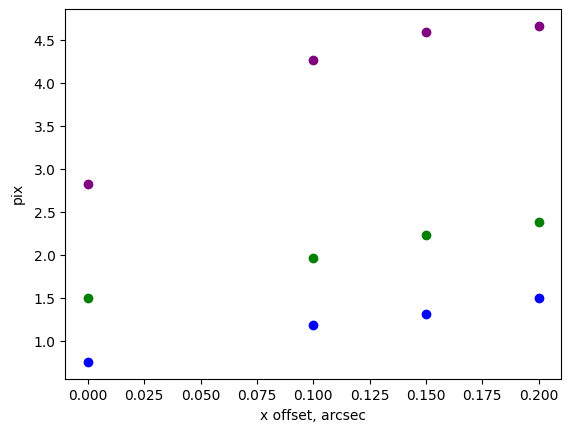

In [28]:
## Varying x-offset, how does the psf pixel-spread change?
wns = webbpsf.NIRSpec()

wns.detector = 'NRS2'
wns.image_mask = 'Single MSA open shutter'

for wav in [1.4]:
    ## choose xs
    for rad, theta in [(0,0), (0.1, -90), (0.15, -90), (0.2, -90)]:
        wns.options['source_offset_r'] = rad
        wns.options['source_offset_theta'] = theta
    
        %time psf = wns.calc_psf(monochromatic=(wav*u.micron).to(u.meter).value, oversample=8, fov_arcsec=1)
        print('PSF with r=' + str(rad) + ' and theta=' + str(theta) + ' at ' + str(wav) + ' (micron)')
        
        hdu = psf['OVERDIST']
        
        qs = [0.68, 0.95, 0.997]#, 0.995, 0.999]

        pxg, pyg = psf_pix_grid(hdu)
        r = np.hypot(pxg, pyg)
        sorti = np.argsort(r.ravel())
        x = r.ravel()[sorti]
        y = np.cumsum(hdu.data.ravel()[sorti])
        y = y/y[-1] 

        print(np.interp(qs, y, x/(hdu.header['PIXELSCL']*u.arcsec/u.pixel)/hdu.header['OVERSAMP'])[0])
        print(rad)
        #1 sigma
        plt.scatter(rad, np.interp(qs, y, x/(hdu.header['PIXELSCL']*u.arcsec/u.pixel)/hdu.header['OVERSAMP'])[0], color = 'blue')
        #2 sigma
        plt.scatter(rad, np.interp(qs, y, x/(hdu.header['PIXELSCL']*u.arcsec/u.pixel)/hdu.header['OVERSAMP'])[1], color = 'green')
        #3 sigma
        plt.scatter(rad, np.interp(qs, y, x/(hdu.header['PIXELSCL']*u.arcsec/u.pixel)/hdu.header['OVERSAMP'])[2], color = 'purple')

        print(np.interp(qs, y, x/(hdu.header['PIXELSCL']*u.arcsec/u.pixel)/hdu.header['OVERSAMP']), 'detector sampled')
plt.xlabel('x offset, arcsec')
plt.show()

CPU times: user 11.4 s, sys: 593 μs, total: 11.4 s
Wall time: 9.82 s
PSF with r=0 and theta=0 at 1 (micron)
0.7126096406869613 pix
0
[0.71260964 1.69788471 2.44019564] pix detector sampled
CPU times: user 10.5 s, sys: 0 ns, total: 10.5 s
Wall time: 8.7 s
PSF with r=0.1 and theta=-90 at 1 (micron)
1.142555867310482 pix
0.1
[1.14255587 2.13782892 3.35992001] pix detector sampled
CPU times: user 8.52 s, sys: 19.3 ms, total: 8.54 s
Wall time: 6.97 s
PSF with r=0.15 and theta=-90 at 1 (micron)
1.2655285457072867 pix
0.15
[1.26552855 2.3799291  3.61096421] pix detector sampled
CPU times: user 8.5 s, sys: 9.45 ms, total: 8.51 s
Wall time: 6.93 s
PSF with r=0.2 and theta=-90 at 1 (micron)
1.3721561500062593 pix
0.2
[1.37215615 2.47645159 3.49665018] pix detector sampled
CPU times: user 8.41 s, sys: 9.58 ms, total: 8.42 s
Wall time: 6.89 s
PSF with r=0 and theta=0 at 1.2 (micron)
0.7126096406869613 pix
0
[0.71260964 1.71619128 2.48903847] pix detector sampled
CPU times: user 8.46 s, sys: 18.7 m

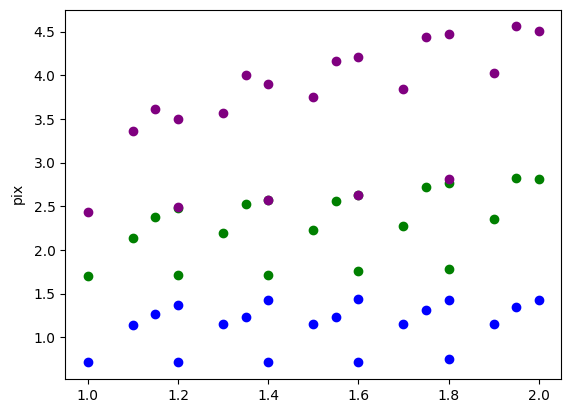

In [28]:
## Horizontal offset AND wavelength: how does the psf pixel-spread change in width?
wns = webbpsf.NIRSpec()

wns.detector = 'NRS2'
wns.image_mask = 'Single MSA open shutter'

qs = [0.68, 0.95, 0.997]

for wav in [1, 1.2, 1.4, 1.6, 1.8]:
    ## choose xs
    for rad, theta in [(0,0), (0.1, -90), (0.15, -90), (0.2, -90)]:
        wns.options['source_offset_r'] = rad
        wns.options['source_offset_theta'] = theta
    
        %time psf = wns.calc_psf(monochromatic=(wav*u.micron).to(u.meter).value, oversample=8, fov_arcsec=1)
        print('PSF with r=' + str(rad) + ' and theta=' + str(theta) + ' at ' + str(wav) + ' (micron)')

        hdu = psf['OVERDIST']

        pxg, pyg = psf_pix_grid(hdu)
        r = np.hypot(pxg, pyg)
        sorti = np.argsort(r.ravel())
        x = r.ravel()[sorti]
        y = np.cumsum(hdu.data.ravel()[sorti])
        y = y/y[-1] 

        print(np.interp(qs, y, x/(hdu.header['PIXELSCL']*u.arcsec/u.pixel)/hdu.header['OVERSAMP'])[0])
        print(rad)
        #### Each full x-offset group gets shifted by its wavelength. e.g., all 1 micron psfs are the first in their group (exactly at the wavelengths on the x-axis)
        #1 sigma
        plt.scatter(rad+wav, np.interp(qs, y, x/(hdu.header['PIXELSCL']*u.arcsec/u.pixel)/hdu.header['OVERSAMP'])[0], color = 'blue')
        #2 sigma
        plt.scatter(rad+wav, np.interp(qs, y, x/(hdu.header['PIXELSCL']*u.arcsec/u.pixel)/hdu.header['OVERSAMP'])[1], color = 'green')
        # 3 sigma
        plt.scatter(rad+wav, np.interp(qs, y, x/(hdu.header['PIXELSCL']*u.arcsec/u.pixel)/hdu.header['OVERSAMP'])[2], color = 'purple')

        print(np.interp(qs, y, x/(hdu.header['PIXELSCL']*u.arcsec/u.pixel)/hdu.header['OVERSAMP']), 'detector sampled')
plt.show()

##### in-slit position seems much more important than wavelength dependence, at least in the x-direction (dispersion direction)